## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import random
random.seed(42)
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [94]:
ckd = pd.read_csv("chronic_kidney_disease_full.csv")
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:
1. check `ckd` variable to check if there is an unbalance
2. `ckd` is to be predictedm compare `ckd` to see which variable have more weight on prediction of `ckd`
3. check missing values and how many missing for each feature/ any missing values will be a problem
4. check out the distribution of each variable, are there extreme values?
5. relationship amongst the features themselves.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [95]:
ckd.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [96]:
100 * ckd.isnull().sum() / ckd.shape[0]

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

Most columns have data missing, `rbc`, `wbcc`, and `rbcc` missing over 100 observations each. They are also missing over 15% of data. This is a source for concern.

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [97]:
ckd.dropna(axis = 0, how = 'any', inplace = False).shape

(158, 25)

In [98]:
ckd.dropna(axis = 0, how = 'any', inplace = False)['class'].value_counts()

notckd    115
ckd        43
Name: class, dtype: int64

Answer:
we will be dropping 242 out of 400 observations if all rows with missing values are dropped. 
This is not acceptable.
many of the rows have information that we still need. 
also, if NaN itself holds information, such as test not conducted, it should not be dropped.
also, if simply drop, a large portion of CKD will be dropped and only a small part of Not CKD will be dropped.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:  
Some variables may be subjective. Such as sppetite.  
Other viarables that's currently binary may have more than 2 states. For example how the red blood cells are abnormal.  
Data gathered may be inaccurate as well. Due to human error or machine error.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: reply that every one have CKD.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We are optimising for sensitivity. We maximized true positive and minimized false negative. 

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:  
Those who are true negative will be told that they are positive. There will be a lot of false positive and thus some may pursue unneccessary treatment which could result in medical problems.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer:  
tell everyone they do not have CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:  
optimize for specificity. minimizing false positive.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer:  
those with CKD will not get treated.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [99]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [100]:
ckd['y'] = [1 if i == 'ckd' else 0 for i in ckd['class']]

In [101]:
ckd['y'].value_counts()

1    250
0    150
Name: y, dtype: int64

In [102]:
ckd['pc_pcc_interaction'] = [1 if ckd.loc[i, 'pc'] == 'abnormal' and ckd.loc[i, 'pcc'] == 'present' else 0 for i in range(len(ckd['pc']))]

In [103]:
ckd['wbcc_rbcc_interaction'] = ckd['wbcc'] * ckd['rbcc']

In [104]:
ckd.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,htn,dm,cad,appet,pe,ane,class,y,pc_pcc_interaction,wbcc_rbcc_interaction
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,yes,yes,no,good,no,no,ckd,1,0,40560.0
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,no,no,no,good,no,no,ckd,1,0,NaN
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,no,yes,no,poor,no,yes,ckd,1,0,NaN
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,yes,no,no,poor,yes,yes,ckd,1,1,26130.0
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,no,no,no,good,no,no,ckd,1,0,33580.0


In [105]:
ckd.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class', 'y', 'pc_pcc_interaction',
       'wbcc_rbcc_interaction'],
      dtype='object')

In [106]:
ckd.dtypes

age                      float64
bp                       float64
sg                       float64
al                       float64
su                       float64
rbc                       object
pc                        object
pcc                       object
ba                        object
bgr                      float64
bu                       float64
sc                       float64
sod                      float64
pot                      float64
hemo                     float64
pcv                      float64
wbcc                     float64
rbcc                     float64
htn                       object
dm                        object
cad                       object
appet                     object
pe                        object
ane                       object
class                     object
y                          int64
pc_pcc_interaction         int64
wbcc_rbcc_interaction    float64
dtype: object

In [107]:
rbc_abnormal = pd.get_dummies(ckd['rbc'])['abnormal']

In [108]:
pc_abnormal = pd.get_dummies(ckd['pc'])['abnormal']

In [109]:
pcc_present = pd.get_dummies(ckd['pcc'])['present']

In [110]:
ba_present = pd.get_dummies(ckd['ba'])['present']

In [111]:
htn_yes = pd.get_dummies(ckd['htn'])['yes']

In [112]:
dm_yes = pd.get_dummies(ckd['dm'])['yes']

In [113]:
cad_yes = pd.get_dummies(ckd['cad'])['yes']

In [114]:
appet_poor = pd.get_dummies(ckd['appet'])['poor']

In [115]:
pe_yes = pd.get_dummies(ckd['pe'])['yes']

In [116]:
ane_yes = pd.get_dummies(ckd['ane'])['yes']

In [117]:
quant = ckd[['age', 'bp', 'sg', 'al', 'su', 'bgr',
                 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv',
                 'wbcc', 'rbcc', 'pc_pcc_interaction',
                 'wbcc_rbcc_interaction']]

qual = pd.DataFrame([ane_yes, pe_yes, rbc_abnormal, pc_abnormal,
                     pcc_present, ba_present, htn_yes, dm_yes,
                     cad_yes, appet_poor], index=['ane_yes', 'pe_yes', 'rbc_abnormal',
                                                  'pc_abnormal', 'pcc_present',
                                                  'ba_present', 'htn_yes', 'dm_yes',
                                                  'cad_yes', 'appet_poor']).T

In [118]:
X = quant.merge(right = qual, left_index = True, right_index = True)

In [119]:
X

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,ane_yes,pe_yes,rbc_abnormal,pc_abnormal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0,0,0,0,0,0,1,1,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,1,1,0,1,1,0,1,0,0,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,140.0,49.0,0.5,150.0,4.9,...,0,0,0,0,0,0,0,0,0,0
396,42.0,70.0,1.025,0.0,0.0,75.0,31.0,1.2,141.0,3.5,...,0,0,0,0,0,0,0,0,0,0
397,12.0,80.0,1.020,0.0,0.0,100.0,26.0,0.6,137.0,4.4,...,0,0,0,0,0,0,0,0,0,0
398,17.0,60.0,1.025,0.0,0.0,114.0,50.0,1.0,135.0,4.9,...,0,0,0,0,0,0,0,0,0,0


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X.fillna(X.mean()),
                                                    ckd['y'],
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [121]:
parameters = {'C': [0.001, 0.01, 0.1, 1, 10],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

In [122]:
lr = LogisticRegression(solver = 'liblinear', 
                        max_iter = 1000,
                        random_state = 42)

In [123]:
gs_results = GridSearchCV(estimator = lr,                                    # Specify the model we want to GridSearch.
                          param_grid = parameters,                           # Specify the grid of parameters we want to search.
                          scoring = 'recall',                                # Specify recall as the metric to optimize 
                          cv = 5).fit(X_train, y_train)                      # Set 5-fold cross-validation, then fit. (Default is 3.)

In [124]:
gs_results.best_estimator_.get_params()

{'C': 10,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [125]:
logit = LogisticRegression(solver = 'liblinear', 
                           max_iter = 1000,
                           C = 10,
                           class_weight = 'balanced',
                           penalty = 'l2',
                           random_state = 42)

In [126]:
logit.fit(X = X_train,
          y = y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

In [127]:
logit.score(X_train, y_train)

0.9857142857142858

In [128]:
logit.score(X_test, y_test)

0.975

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [129]:
list(zip(np.exp(logit.coef_[0]),X.columns))

[(1.0100249516193545, 'age'),
 (1.1229466898639622, 'bp'),
 (1.1841643706789984, 'sg'),
 (29.660217339361278, 'al'),
 (2.8410676173300202, 'su'),
 (1.0370311580503455, 'bgr'),
 (0.9278470968701984, 'bu'),
 (11.663330740068206, 'sc'),
 (1.067512448638087, 'sod'),
 (1.3321664557592736, 'pot'),
 (0.18827581043976535, 'hemo'),
 (1.0060817624361762, 'pcv'),
 (0.9996284763303958, 'wbcc'),
 (0.3573387202305498, 'rbcc'),
 (1.0665332694530634, 'pc_pcc_interaction'),
 (1.0000723756013732, 'wbcc_rbcc_interaction'),
 (1.6219190185291226, 'ane_yes'),
 (5.415413341297287, 'pe_yes'),
 (2.0642799895718627, 'rbc_abnormal'),
 (1.9377869830878265, 'pc_abnormal'),
 (1.0830389435239773, 'pcc_present'),
 (1.0239373055256853, 'ba_present'),
 (4.150553105665693, 'htn_yes'),
 (4.038479742311785, 'dm_yes'),
 (1.0593760324602566, 'cad_yes'),
 (4.577470133950307, 'appet_poor')]

for every unit increase in `al` there will be 29.66 times more likely for patient to be have CKD.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

if `rbc_abnormal` is true, patient is 2.06 times more likely to have CKD.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:  
1. Explainable coefficients.
2. Simple to use as qucik and dirty baseline model.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

Test data. We can use it to evaluate the actual performance of our matrix.

In [133]:
y_preds = logit.predict(X_test)

In [136]:
cf_matrix = confusion_matrix(y_test, y_preds)

<AxesSubplot: >

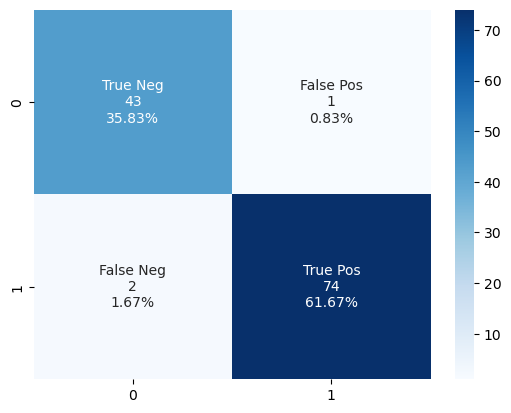

In [139]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer:  
Probably both, but with an emphasis on sensitivity.
Sensitivity ==> focus on minimum flase neg
Specificty ==> minimum flase pos
Since it is a diease, it is better to be safe than sorry. However, purely focusing in sensitivity will result in wastage of money and medical resources.   
But sensitivity is more important as folow up checks can reduce false positive. Patients who need help may not recieve help when they are false negative.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer:  
Harder for model to learn on the minority class. Not enough data for model to learn the behavaiour of minority class.  
Not a problem here becasue the unbalance is not that bad.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:  
rare dieases are harder to diagonse.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [140]:
ckd_sample = ckd[ckd['class'] == 'ckd'].sample(200_000,            # sample n = 200,000
                                               replace = True,     # sample with replacement
                                               random_state = 42)  # set random state

In [141]:
ckd_2 = pd.concat([ckd, ckd_sample])

In [142]:
ckd_2.shape

(200400, 28)

In [143]:
ckd_2.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,htn,dm,cad,appet,pe,ane,class,y,pc_pcc_interaction,wbcc_rbcc_interaction
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,yes,yes,no,good,no,no,ckd,1,0,40560.0
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,no,no,no,good,no,no,ckd,1,0,NaN
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,no,yes,no,poor,no,yes,ckd,1,0,NaN
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,yes,no,no,poor,yes,yes,ckd,1,1,26130.0
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,no,no,no,good,no,no,ckd,1,0,33580.0


In [144]:
100 * ckd_2['class'].value_counts() / len(ckd_2['class'])

ckd       99.92515
notckd     0.07485
Name: class, dtype: float64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [145]:
quant = ckd_2[['age', 'bp', 'sg', 'al', 'su', 'bgr',
                 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv',
                 'wbcc', 'rbcc', 'pc_pcc_interaction',
                 'wbcc_rbcc_interaction', 'y']].copy()     # Since we are modifying the df, copy it!

quant.loc[:,'rbc_abnormal_2'] = pd.get_dummies(ckd_2['rbc'])['abnormal']
quant.loc[:,'pc_abnormal_2'] = pd.get_dummies(ckd_2['pc'])['abnormal']
quant.loc[:,'pcc_present_2'] = pd.get_dummies(ckd_2['pcc'])['present']
quant.loc[:,'ba_present_2'] = pd.get_dummies(ckd_2['ba'])['present']
quant.loc[:,'htn_yes_2'] = pd.get_dummies(ckd_2['htn'])['yes']
quant.loc[:,'dm_yes_2'] = pd.get_dummies(ckd_2['dm'])['yes']
quant.loc[:,'cad_yes_2'] = pd.get_dummies(ckd_2['cad'])['yes']
quant.loc[:,'appet_poor_2'] = pd.get_dummies(ckd_2['appet'])['poor']
quant.loc[:,'pe_yes_2'] = pd.get_dummies(ckd_2['pe'])['yes']
quant.loc[:,'ane_yes_2'] = pd.get_dummies(ckd_2['ane'])['yes']

In [146]:
quant.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,rbc_abnormal_2,pc_abnormal_2,pcc_present_2,ba_present_2,htn_yes_2,dm_yes_2,cad_yes_2,appet_poor_2,pe_yes_2,ane_yes_2
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,0,0,0,0,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,0,0,0,0,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,1,0,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [147]:
quant.shape

(200400, 27)

In [148]:
quant.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
       'pcv', 'wbcc', 'rbcc', 'pc_pcc_interaction', 'wbcc_rbcc_interaction',
       'y', 'rbc_abnormal_2', 'pc_abnormal_2', 'pcc_present_2', 'ba_present_2',
       'htn_yes_2', 'dm_yes_2', 'cad_yes_2', 'appet_poor_2', 'pe_yes_2',
       'ane_yes_2'],
      dtype='object')

In [149]:
X_train, X_test, y_train, y_test = train_test_split(quant.fillna(quant.mean()).drop(['y'],
                                                                                    axis = 1),
                                                    quant['y'],
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [150]:
logit_2 = LogisticRegression(solver = 'liblinear',   # to compare with before
                             max_iter = 1000,
                             C = 10,
                             random_state = 42,
                             penalty = 'l2')

In [151]:
logit_2.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [153]:
print(classification_report(y_test,
                            logit_2.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        56
           1       1.00      1.00      1.00     60064

    accuracy                           1.00     60120
   macro avg       1.00      0.84      0.90     60120
weighted avg       1.00      1.00      1.00     60120



sensitivity ==> recall ==> true pos rate  
This model seems to have performed better.  
But this is may be due to many factors, such as model does not need to many entries to learn `ckd`.  
The number of metrics used to compare should also not be limited to sensitivity.

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!